In [ ]:
import pandas as pd

from transformers import AutoModel, AutoTokenizer
# from transformers import MarianMTModel
from transformers import XLMRobertaForSequenceClassification

from tqdm import tqdm
tqdm.pandas()
%matplotlib inline

In [9]:
def detect_language(model, tokenizer, text):
    
    token_dict = tokenizer(text, return_tensors="pt").to("cuda")
    outputs = model(token_dict.input_ids)
    decoded = outputs.logits.argmax(-1).item()
    lang = model.config.id2label[decoded]
    return lang

In [68]:
dataset_path = "../data/dataset.csv"
output_path = "../data/clean_dataset.csv"

df = pd.read_csv(dataset_path, index_col=0)
df

text  label
7                                               fuck you      1
32         hell fucking biatch ass licking but fuckinger      1
33                                        fuck you bitch      1
59                                              fuck you      1
61                                              piss off      1
...                                                  ...    ...
3993   quand il n'est plus possible d'établir des lie...      0
3999   quand vous prendrez vos sources ailleurs que s...      0
4002   je suis actuellement en amerique je suis en hi...      0
4013   pourquoi tant de migrants africains en europe ...      0
label                                                  0      0

[66224 rows x 2 columns]

In [8]:
# Language detection model
tokenizer = AutoTokenizer.from_pretrained("papluca/xlm-roberta-base-language-detection")
model = XLMRobertaForSequenceClassification.from_pretrained("papluca/xlm-roberta-base-language-detection").to("cuda")

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [12]:
detect_language(model, tokenizer, df.iloc[0].text)

'en'

In [15]:
df["language"] = df.text.progress_apply(lambda x: detect_language(model, tokenizer, x))

100%|████████████████████████████████████████████████████████████████████████████████| 66224/66224 [08:31<00:00, 129.51it/s]


<AxesSubplot: >

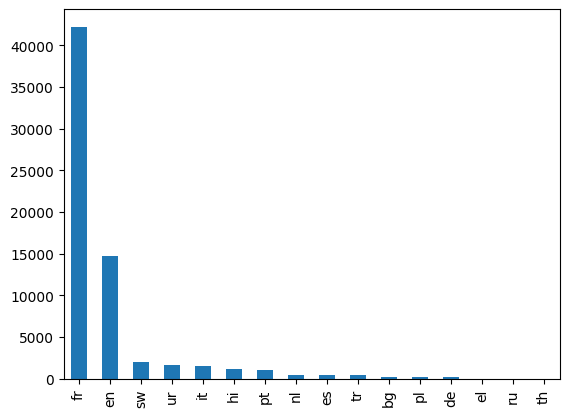

In [18]:
df.language.value_counts().plot.bar()

In [19]:
errors_df = df.loc[df.language != "fr"]
errors_df.shape

(24002, 3)

In [23]:
errors_df.loc[errors_df.language != "en"].sample(20)

text  \
3218                                                     oshi que mongol   
[2019-06-13 14:16:49]                               toi ta mere c satan    
235                    Fascist republican profiteers nazi pigs https:...   
[2019-06-13 14:33:42]                                             boucje   
9203                                                            yes i am   
2783                                                        buenos aires   
[2019-06-13 14:32:11]                                            salope    
3228                                             gay men aren't real men   
2814                   @Btlabeutax93 @AntiChanell Mdrrrr wesh jtarran...   
3005                                                                  no   
8460                                                             i wan't   
1031                                   "Comme si Hitler n'existait pas !   
[2019-06-13 14:29:04]                                            Adrien    
[2019-06-13 14:31:44]                                                ...   
2260                   @TeikOoFN @Sweafts @wahxbb Tu penses j'en reço...   
1844                                                      Trichirappalli   
6357                                                                 lax   
[2019-06-13 14:22:19]                                              pute    
8913                                                                 Yep   
[2019-06-13 14:28:14]                                    sylvia ouuouuu?   

                       label language  
3218                       0       sw  
[2019-06-13 14:16:49]      1       hi  
235                        1       it  
[2019-06-13 14:33:42]      0       pl  
9203                       0       sw  
2783                       0       es  
[2019-06-13 14:32:11]      1       bg  
3228                       1       nl  
2814                       0       tr  
3005                       0       sw  
8460                       0       sw  
1031                       0       it  
[2019-06-13 14:29:04]      0       nl  
[2019-06-13 14:31:44]      0       hi  
2260                       1       nl  
1844                       0       hi  
6357                       0       it  
[2019-06-13 14:22:19]      0       ur  
8913                       0       sw  
[2019-06-13 14:28:14]      0       pt

In [39]:
clean_df = df.loc[df.language == "fr"]

# Check language predictions using specific stopword list
stopwords = ["conne", "salope", "mere"]

pred_errors = errors_df.loc[errors_df.text.str.contains("|".join(stopwords))]
print("Pred errors :", pred_errors.shape[0])
clean_df = pd.concat([clean_df, pred_errors])
clean_df["language"] = "fr"
clean_df

Pred errors : 441


text  \
5823                                                            dumb bot   
6783                                                            dumb bot   
8898                                                            dumb bot   
[2019-06-13 14:12:47]      t as vu ce que t as fait a la soiré sale pute   
[2019-06-13 14:14:56]   je suis espagnol pardon de ne pas tout savoir...   
...                                                                  ...   
[2019-06-13 14:32:11]                                            salope    
[2019-06-13 14:16:49]                               toi ta mere c satan    
[2019-06-13 14:22:15]                                            t conne   
[2019-06-13 14:22:22]                                            salope    
[2019-06-13 14:32:11]                                            salope    

                       label language  
5823                       1       fr  
6783                       1       fr  
8898                       1       fr  
[2019-06-13 14:12:47]      1       fr  
[2019-06-13 14:14:56]      1       fr  
...                      ...      ...  
[2019-06-13 14:32:11]      0       fr  
[2019-06-13 14:16:49]      0       fr  
[2019-06-13 14:22:15]      0       fr  
[2019-06-13 14:22:22]      0       fr  
[2019-06-13 14:32:11]      0       fr  

[42663 rows x 3 columns]

### Manual postprocessing

Remove manually detected wrong language rows

In [47]:
ids = ["5823", "6783", "8898", "1966"]

manual_clean_df = clean_df.loc[clean_df.index.isin(ids) == False]
manual_clean_df

text  \
[2019-06-13 14:12:47]      t as vu ce que t as fait a la soiré sale pute   
[2019-06-13 14:14:56]   je suis espagnol pardon de ne pas tout savoir...   
[2019-06-13 14:15:18]   tu as embrasser Lucas alors que sophia est ta...   
[2019-06-13 14:15:27]            tu as foutu la merde dans leurs couple    
[2019-06-13 14:15:31]                                   c'est dégeulasse   
...                                                                  ...   
[2019-06-13 14:32:11]                                            salope    
[2019-06-13 14:16:49]                               toi ta mere c satan    
[2019-06-13 14:22:15]                                            t conne   
[2019-06-13 14:22:22]                                            salope    
[2019-06-13 14:32:11]                                            salope    

                       label language  
[2019-06-13 14:12:47]      1       fr  
[2019-06-13 14:14:56]      1       fr  
[2019-06-13 14:15:18]      1       fr  
[2019-06-13 14:15:27]      1       fr  
[2019-06-13 14:15:31]      1       fr  
...                      ...      ...  
[2019-06-13 14:32:11]      0       fr  
[2019-06-13 14:16:49]      0       fr  
[2019-06-13 14:22:15]      0       fr  
[2019-06-13 14:22:22]      0       fr  
[2019-06-13 14:32:11]      0       fr  

[42660 rows x 3 columns]

In [63]:
manual_clean_df.sample(20)

text  \
[2019-06-13 14:21:43]                          apprend a écrire connasse   
[2019-06-13 14:21:42]                    il leur paie des apparts privés   
3333                   la pauvreté n'est le collateral de la violence...   
827                    "Les décès massifs qui ont lieu en Afghanistan...   
2674                   @Arashi_Storm @Jubaieuh par contre dire que je...   
1023                   @TeTr4_Live Non mais totalement... Bon Zemmour...   
284                    homme si une dame a essayé de se mettre entre ...   
664                    rt  l'histoire du quebec vaut la peine qu'on s...   
[2019-06-13 14:28:44]                     déso j'avais plus de connexion   
609                    @CommanderTorenn On va faire court,je ne m,int...   
[2019-06-13 14:35:20]        au moins j'arrive à me faire embrasse Diana   
[2019-06-13 14:32:35]                                       Mais oui...    
137                    @djoulye @LiorahDouge @barriere_dr @MahmoudZur...   
1293                   ptdrrr tout les «anti satanistes/theorie du co...   
[2019-06-13 14:35:04]                     au moins mon pere est pas mort   
1602                   @LamoloQc @tvanouvelles On ne sera plus là pou...   
[2019-06-13 14:16:49]                               toi ta mere c satan    
[2019-06-13 14:24:51]                 t'es venu au nom de dieu Herbert?    
[2019-06-13 14:11:46]                                Salut Adri,  ça va?   
[2019-06-13 14:32:11]                                            salope    

                       label language  
[2019-06-13 14:21:43]      0       fr  
[2019-06-13 14:21:42]      0       fr  
3333                       0       fr  
827                        0       fr  
2674                       0       fr  
1023                       0       fr  
284                        0       fr  
664                        0       fr  
[2019-06-13 14:28:44]      0       fr  
609                        0       fr  
[2019-06-13 14:35:20]      0       fr  
[2019-06-13 14:32:35]      0       fr  
137                        0       fr  
1293                       0       fr  
[2019-06-13 14:35:04]      0       fr  
1602                       0       fr  
[2019-06-13 14:16:49]      1       fr  
[2019-06-13 14:24:51]      0       fr  
[2019-06-13 14:11:46]      0       fr  
[2019-06-13 14:32:11]      0       fr

In [69]:
manual_clean_df.to_csv(output_path)